<a href="https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/Best_Practices_for_Views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

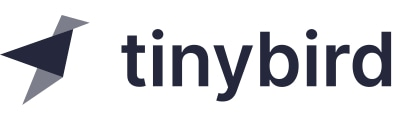
#Principles of Real-Time Analytics Course

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

% cd "/content/gdrive/My Drive/Colab Notebooks/Tinybird"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Tinybird


In [ ]:
def write_text_tofile(filename, text):
  with open(filename, 'w') as f:
      f.write(text)

In [ ]:
!pip install tinybird-cli -q
!tb auth

Copy the admin token from https://ui.tinybird.co/tokens and paste it here: 
** Auth successful! 
** Configuration written to .tinyb file, consider adding it to .gitignore


# Best Practices for Views
Views are a really powerful tool to analyze large amounts of data really quickly. Normal views do not store any data, they just perform a read from another table on each access. Materialized views store data transformed by the corresponding SELECT query. Live views store the result of the corresponding SELECT query and are updated any time the result of the query changes. 

We usually talk about materialized and live views. Here we will focus on materialized views here because they really help solving some real-time problems.

Materialized views are useful because if you frequently run the same query on a table it makes sense to run the query once, save the result and just fetch that result. They have two downsides:
 - They need space.
 - They add management work (especially recalculating them when new data comes in). 
 - They need to be updated and changed if the source schema changes.
 - They generally only work for some use cases.


Let’s see how to manage these issues and leverage views to get 100-1000x improvements.

Views are a way to trade memory and disk to save CPU. That means we will have more things in disk/memory but when we need to use them the CPU will need to fetch less data or do less work than if they didn’t exist.

This means spending more money on disk and less money on CPUs. This is a very good tradeoff since, in the cloud, each CPU can be around 25x more expensive than each GB of disk.

Here we see some use cases and best practices.



## Denormalization on Ingest
This is one of the most common use cases. It means calculating things when the data arrives (on ingestion time) so that you save a version of your original data with extra/enriched/prepared data. You could do the same operations at query time but when you do them on ingest time you execute the operation once and query many times (so the query time is less than it would be without the view).


### Join with a Dimensions Dataset
Here we use the New York City Taxi Trip dataset and the join table `taxi__zone_lookup` to add columns for the pick-up and drop-off boroughs from the dimensions table to the main table using a pipe. The datasources are created [here](https://colab.research.google.com/drive/1dvZAaHs-Xp3QpCUOPpl_Nb97YilLLZp2?usp=sharing). 

In [ ]:
filename = 'pipes/denormalize_taxi.pipe'
text='''
NODE denormalized
SQL >
    SELECT 
    *,
    joinGet('taxi__zone_lookup', 'borough', dolocationid) doborough,
    joinGet('taxi__zone_lookup', 'borough', pulocationid) puborough
    FROM taxi

'''

write_file(filename, text)

In [ ]:
!cat pipes/denormalize_taxi.pipe


NODE denormalized
SQL >
    SELECT 
    *,
    joinGet('taxi__zone_lookup', 'borough', dolocationid) doborough,
    joinGet('taxi__zone_lookup', 'borough', pulocationid) puborough
    FROM taxi



In [ ]:
!tb push --populate --force pipes/denormalize_taxi.pipe

** Processing pipes/denormalize_taxi.pipe
** Building dependencies
** Running denormalize_taxi 
** => Test endpoint at https://api.tinybird.co/v0/pipes/denormalize_taxi.json
** 'denormalize_taxi' created
** Not pushing fixtures


In [ ]:
!tb sql "SELECT * FROM denormalize_taxi LIMIT 1"

------------------------------------------
vendorid: 1
tpep_pickup_datetime: 2019-08-17 12:04:03
tpep_dropoff_datetime: 2019-08-17 12:14:41
passenger_count: 1
trip_distance: 1.5
ratecodeid: 1
store_and_fwd_flag: N
pulocationid: 68
dolocationid: 164
payment_type: 1
fare_amount: 9
extra: 2.5
mta_tax: 0.5
tip_amount: 2.45
tolls_amount: 0
improvement_surcharge: 0.3
total_amount: 14.75
congestion_surcharge: 2.5
doborough: Manhattan
puborough: Manhattan
------------------------------------------


### Precalculate Something that would Take a Lot of CPU cycles
Imagine that you have a column that is calculated from others in the table. You could calculate it on ingestion time to avoid running those calculations during the query. 

In this simple example the estimated trip fare is calculated although calculations are usually more complex than just a multiplication.


In [ ]:
!tb sql --stats "SELECT avg(fare_amount/trip_distance) AS avg_per_mile FROM taxi WHERE trip_distance > 0"

** Query took 0.074803347 seconds
** Rows read: 84,152,418
** Bytes read: 673.22 MB
---------------------
|      avg_per_mile |
---------------------
| 7.807361125726695 |
---------------------


If we create a materialized view of the taxi table with an additional column for the  estimated fare then we can run fast queries without the calculation.

First we create the taxi_mv datasource with the additional column for `estimated_fare`.

In [ ]:
filename="datasources/taxi_mv.datasource"
text='''
SCHEMA >
    `estimated_fare` Float32,
    `vendorid` Int16,
    `tpep_pickup_datetime` DateTime,
    `tpep_dropoff_datetime` DateTime,
    `passenger_count` Nullable(Int16),
    `trip_distance` Float32,
    `ratecodeid` Nullable(Int16),
    `store_and_fwd_flag` String,
    `pulocationid` Int32,
    `dolocationid` Int32,
    `payment_type` Nullable(Int16),
    `fare_amount` Float32,
    `extra` Float32,
    `mta_tax` Float32,
    `tip_amount` Float32,
    `tolls_amount` Float32,
    `improvement_surcharge` Float32,
    `total_amount` Float32,
    `congestion_surcharge` Nullable(Float32)

ENGINE "MergeTree"
ENGINE_PARTITION_KEY "toMonth(tpep_pickup_datetime)"
ENGINE_SORTING_KEY "tpep_pickup_datetime"
'''

write_file(filename, text)

In [ ]:
!tb push datasources/taxi_mv.datasource

** Processing datasources/taxi_mv.datasource
** Building dependencies
** Running taxi_mv 
** 'taxi_mv' created
** Not pushing fixtures


In [ ]:
filename = 'pipes/cost_estimate.pipe'
text = '''
NODE cost_estimate_node
SQL >

    SELECT
trip_distance * 7.807361125727003 AS estimated_fare,
        *
    FROM taxi

TYPE materialized
DATASOURCE taxi_mv
'''

write_file(filename, text)

In [ ]:
!tb push pipes/cost_estimate.pipe --skip-table-checks --populate

** Processing pipes/cost_estimate.pipe
** Building dependencies
** Running cost_estimate 
** Materialized node 'cost_estimate_node' used the Data Source 'taxi_mv'
** Populating job url https://api.tinybird.co/v0/jobs/b8068369-f142-4a47-b21c-57c960343b85
** 'cost_estimate' created
** Not pushing fixtures


In [ ]:
!tb sql --stats "SELECT estimated_fare, fare_amount FROM cost_estimate LIMIT 15"

** Query took 0.001537145 seconds
** Rows read: 15
** Bytes read: 120 bytes
--------------------------------
| estimated_fare | fare_amount |
--------------------------------
|      3.3571653 |         3.5 |
|      25.139704 |        13.5 |
|              0 |        11.5 |
|              0 |         2.5 |
|              0 |           0 |
|              0 |           0 |
|              0 |           0 |
|              0 |           0 |
|       67.84596 |          34 |
|      112.89444 |          40 |
|      11.320674 |          10 |
|       24.04667 |          11 |
|      26.232733 |        14.5 |
|      14.521692 |          10 |
|       8.666171 |           9 |
--------------------------------


The estimation algorithm is not very good 😅 but the query is super fast and reads little data.

### Precalculate Something that will Help when Joining with other Datasets at Query Time

If you have a join like

```
SELECT * 
FROM A 
JOIN B 
ON A.id = B.id and A.foo = B.foo
-- using id, foo
```

As we saw, you could have an extra column with id + foo so the query would be

```
SELECT * 
FROM A 
JOIN B 
ON A.foo_id = B.foo_id
WHERE attr = 1
````

This speeds up the join because you just read one parameter and just check once. Not only that, it also enables (if your database supports it) hash join which is much faster.

### JSON Data Denormalization

## Use Arrays to Denormalize
A way to save a lot of rows is to use arrays. Mostly for secondary use cases or the ones you would join after a filter.

For example, if we have a table `user_events` with all the mouse clicks or taps during a session, it might make sense to save all of them in the same row using an array instead of saving one row per click. In other words, it’s a way to save a join.

The downside is that databases don’t usually have inverted indices so you might want to generate another column or columns based on array content to be able to index.

In this example, if we define the table as:
```
UserId UInt64
Timestamp DateTime
ClickPoints Array(Int32, Int32)
```
Then we could do a query to search clicks on a particular zone from people older than 70:
```
SELECT x, y from ( 
SELECT * FROM user_events 
JOIN user_info 
USING UserId
WHERE user_info.age > 70
) array join ClickPoints as (x, y)
WHERE x between 10 and 100
```
In this case, if we have, for example, 50 clicks per user as an average, the join will have to do 50x less work. Then the array join generates one entry for each element of the ClickPoints array and we can filter by x, y.

Take into account that this is useful in two main situations:
 - When it allows you to save joins or other expensive operations. If you always need to do the array join this way to store data then it doesn’t make any sense.
 - When you only need the array join for a small % of use cases in which you use the table. Mainly because you optimize the main use case making worse the secondary use cases but improving the timing overall.

## Incremental Views
One of the main problems of views is updating them. That’s why you need to pick a database that allows you to update them incrementally. It does not make any sense to update a view of a 4 billion row table every time you append more data.

So how do you update a view that generates an aggregation? For example,
```
SELECT date, avg(response_time), uniq(user_id) 
FROM events
GROUP BY date
````
You might think the view needs to be fully updated if you append a new event with a new `user_id`. 

You don’t, there are ways to do this really simply. Let’s see an example with the Yandex `hits` dataset. It contains tracking information (like Google Analytics)